In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Step 2 - Get the data

In [3]:
shared_folder_path = '/content/drive/MyDrive/ztm/rag_ztm/multimodal_rag/'

In [4]:
%cd "{shared_folder_path}"

/content/drive/MyDrive/ztm/rag_ztm/multimodal_rag


In [5]:
!ls "{shared_folder_path}"

audios	decision-making-course.mp4  frames  transcripts


In [6]:
# Define the video path
video_path = "decision-making-course.mp4"

## Step 3 - Extract the Audio and Compress

In [7]:
# Install libraries
!pip install -q pydub
!apt-get install -q ffmpeg

Reading package lists...
Building dependency tree...
Reading state information...
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [8]:
# Import libraries
import os
import subprocess
from pydub import AudioSegment

In [9]:
# Define the audio path
audio_output_path = "audios/output.mp3"

In [10]:
# Ensure the output directory exists
output_dir = os.path.dirname(audio_output_path)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [11]:
# Ensure the output file has the correct extension
if not audio_output_path.endswith(".mp3"):
  audio_output_path += ".mp3"

In [12]:
# Construct the ffmpeg command to extract the audio
command = [
    'ffmpeg',
    '-y', # Overwrites if the audio exists
    '-i', video_path, # Input file
    '-vn', # No Video
    '-acodec', 'libmp3lame', # Audio Codecs
    audio_output_path # Output file
]

In [13]:
# Execute the command to extract the audio
subprocess.run(command, check=True)

CompletedProcess(args=['ffmpeg', '-y', '-i', 'decision-making-course.mp4', '-vn', '-acodec', 'libmp3lame', 'audios/output.mp3'], returncode=0)

In [14]:
# Set the bitrate
bitrate = "32k"

In [15]:
# Set path for compressed audio
compressed_audio_path = "audios/compressed.mp3"

In [16]:
# Construct the ffmpeg command to compress the audio
compressed_command = [
    'ffmpeg',
    '-y', # Overwrites if the audio exists
    '-i', audio_output_path, # Input file
    '-ab', bitrate, # Audio bitrate
    compressed_audio_path # Output file
]

In [17]:
subprocess.run(compressed_command, check=True)

CompletedProcess(args=['ffmpeg', '-y', '-i', 'audios/output.mp3', '-ab', '32k', 'audios/compressed.mp3'], returncode=0)

# Step 4 - Transcribe Audio using OpenAI API

In [18]:
# Install the openAI library
! pip install -q openai

In [19]:
# Import OpenAI library
from openai import OpenAI

In [20]:
from google.colab import userdata
api_key = userdata.get('OPENAI_API_KEY')

In [21]:
# Connect to the OpenAI API
client = OpenAI(api_key = api_key)

In [22]:
!pwd

/content/drive/MyDrive/ztm/rag_ztm/multimodal_rag


In [23]:
# Open the compressed audio file in binary mode
with open(compressed_audio_path, "rb") as file:
    # Use the Whisper model to transcribe the audio
    transcript = client.audio.transcriptions.create(
        model="whisper-1",    # Specify the model to use for transcription
        file=file             # Provide the audio file for transcription
    )

In [24]:
# Inspect the transcript
transcript.text

"Are you looking to improve the way that you make decisions? Do you sometimes worry that you don't have all the tools to make the best calls? Or even when you hear other people at work, you sometimes feel, hmm, that does not feel like the right decision, but at the same time, you cannot explain why. Well, I think you are in the right place. In the next one hour, you will have a crash course on decision making, problem solving and critical thinking. I'm going to share with you framework thinking, how we make decisions and cognitive biases. I'm going to show you some very well-known frameworks like system one and system two thinking, loss aversion, and even some cognitive biases like anchoring bias or confirmation bias. By the end of this one hour, you will have better tools to make decisions. And at the same time, just to give you some nudge to actually complete, there is a very nice incentive. So I have a tiny gift for you at the end of this crash course. Are you ready? Let's get start

In [25]:
# Define the path where the transcription will be saved
transcript_path = "transcripts/transcript.txt"

In [26]:
# Ensure the output directory exists
output_dir = os.path.dirname(transcript_path)
# Create the directory if it does not already exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [27]:
# Save the transcribed text to a file
with open(transcript_path, "w") as file:
  file.write(transcript.text) # .text is the attribute from transcrition

In [28]:
# # Save the transcribed text without using "with"
# file = open(transcript_path, "w")
# file.write(transcript.text)
# file.close()

# Step 5 - Extract Frames from the video

In [29]:
# Install the moviepy library to handle video data
!pip install -q moviepy

In [30]:
# Load moviepy library
from moviepy.editor import VideoFileClip

  if event.key is 'enter':



In [34]:
# Define the output folder for storing frames
output_folder = "frames"
if not os.path.exists(output_folder):
  os.makedirs(output_folder)

In [35]:
# Load the video
video = VideoFileClip(video_path)

In [36]:
# Extract the frames
frame_paths = []
interval = 10

for t in range(0, int(video.duration), interval):
  frame_path = os.path.join(output_folder, f"frame_{t:04d}.png")
  # Save the frame at the specified time
  video.save_frame(frame_path, t)
  frame_paths.append(frame_path)

# Step 6 - Embedding Audio

In [37]:
# Import libraries
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
import torch
import numpy as np

In [ ]:
# Load the Model, Processor and Tokenizer
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [39]:
# Get the transcribed text
transcript_text = transcript.text

In [40]:
# Tokenize the entire text
tokens = tokenizer(transcript_text,
                   return_tensors = "pt",
                   padding = True)
tokens = tokens['input_ids'][0]
print(f"The number of tokens is {len(tokens)}")

Token indices sequence length is longer than the specified maximum sequence length for this model (9901 > 77). Running this sequence through the model will result in indexing errors


The number of tokens is 9901


In [41]:
# The CLIP model requires 77 tokens per chunk
max_tokens = 77
transcription_chunks = []

for i in range(0, len(tokens), max_tokens):
  chunk = tokens[i: i + max_tokens]
  transcription_chunks.append(chunk)

print(f"The number of chunks is {len(transcription_chunks)}")

The number of chunks is 129


In [42]:
len(transcription_chunks[0]), transcription_chunks[0].unsqueeze(0).shape

(77, torch.Size([1, 77]))

In [43]:
# Text Embeddings -> embed the tokens in each chunk
text_embeddings = []

for chunk in transcription_chunks:
  # Ensure the chunk is in the correct shape for the model
  inputs = {"input_ids": chunk.unsqueeze(0)}

  # Get the text embedding for the chunk
  with torch.no_grad():
    text_embedding = model.get_text_features(**inputs)
    # Convert the embedding to a numpy array and flatten it
    text_embeddings.append(text_embedding.cpu().numpy().flatten())

# Convert the list of embeddings to a numpy array
text_embedding_np = np.array(text_embeddings)

# Print the shape of the text embeddings array
print(f"Text embedding shape is {text_embedding_np.shape}")

Text embedding shape is (129, 512)


# Step 7 - embedding the images

In [44]:
# Import the PIL library
from PIL import Image

In [45]:
# Embed the images
frames_folder = "frames"
image_embeddings = []
image_paths = []

for frame_file in os.listdir(frames_folder):
  if frame_file.endswith('.png'):
    # Construct the path to the image file
    frame_path = os.path.join(frames_folder, frame_file)
    image_paths.append(frame_path)

    # Load and preprocess the image
    image = Image.open(frame_path)
    inputs = processor(images = image, return_tensors = "pt")

    # Generate the image embeddings
    with torch.no_grad():
      image_embedding = model.get_image_features(**inputs)
      # Convert the embedding to a numpy array and flatten it
      image_embeddings.append(image_embedding.cpu().numpy().flatten())

# Convert the list of embeddings to a numpy array
image_embedding_np = np.array(image_embeddings)

# Print the shape
print(f"Image embedding shape is {image_embedding_np.shape}")

Image embedding shape is (373, 512)


In [46]:
print(f"Image embedding shape is {image_embedding_np.shape}")

Image embedding shape is (373, 512)


# Step 8 - Contrastive Learning

In [47]:
# Import Libraries
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import random

In [48]:
# Calculate the cosine similarity matrix
similarities = cosine_similarity(text_embedding_np, image_embedding_np)
similarities.shape

(129, 373)

**Retrieves and prints the indices of the top top_k most similar images for each text chunk based on the similarities matrix.**

In [51]:
# Retrieve the top-k most similar images for each text chunk
top_k = 5
for i, text_chunk in enumerate(similarities):
  # Get indices of the top-k most similar images
  similar_indices = text_chunk.argsort()[-top_k:][::-1]
  print(f"Top {top_k} images for each chunk {i}: {similar_indices}")

Top 5 images for each chunk 0: [ 94 300 258  21  34]
Top 5 images for each chunk 1: [ 10 233 204 203 123]
Top 5 images for each chunk 2: [205 326 359 114  96]
Top 5 images for each chunk 3: [ 12  11 329 154  13]
Top 5 images for each chunk 4: [ 80  12  62 237 120]
Top 5 images for each chunk 5: [ 17 333 371 327 337]
Top 5 images for each chunk 6: [224 200 226 349 337]
Top 5 images for each chunk 7: [304 200  13   9  65]
Top 5 images for each chunk 8: [357  69 352 356 351]
Top 5 images for each chunk 9: [352 200 351  14 179]
Top 5 images for each chunk 10: [ 72  71 241 239  46]
Top 5 images for each chunk 11: [ 13 202 244 245   9]
Top 5 images for each chunk 12: [ 79 356  78 351 346]
Top 5 images for each chunk 13: [ 12  11  13 255 329]
Top 5 images for each chunk 14: [337 259 203 204  14]
Top 5 images for each chunk 15: [357 135 356 134  46]
Top 5 images for each chunk 16: [265 264 301  73 185]
Top 5 images for each chunk 17: [325 206 204 203  53]
Top 5 images for each chunk 18: [ 31 2

In [53]:
# Set a random seed for reproducibility
random.seed(1502)

# Select 5 random text chunk indices
random_text_indices = random.sample(range(len(text_embedding_np)), 5)
print(f"Random text chunk indices: {random_text_indices}")

Random text chunk indices: [43, 122, 67, 110, 89]


In [54]:
# Find the 3 most similar images for each randomly selected text chunk
text_to_images_similarities = []
for idx in random_text_indices:
  # Get indices of the top 3 most similar images for the text chunk
  similar_images = similarities[idx].argsort()[-3:][::-1]
  text_to_images_similarities.append(similar_images)


  The text chunk 1: powerful , and that it can inter fere with system 2 thinking , even when we consciously try to focus on something else . the st roo p effect can be extremely important when making presentations , as it highlights the influence of non - verbal cues and the way information is presented on our ability to process information accurately . for example , imagine you are making a presentation to a group of stakeholders , and


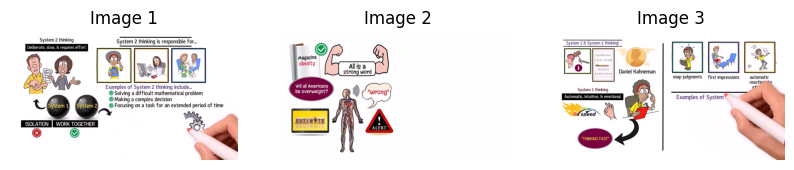


  The text chunk 2: though they would still be above average . the same thing happened to the bottom sec tile . the stores that were there in 1 9 1 6 were not the same as the ones in 1 9 2 2 . they would still be below average , but would no longer be the bottom performers . the same insight was similar in all industries . according to se christ , medi ocr ity tends to prevail


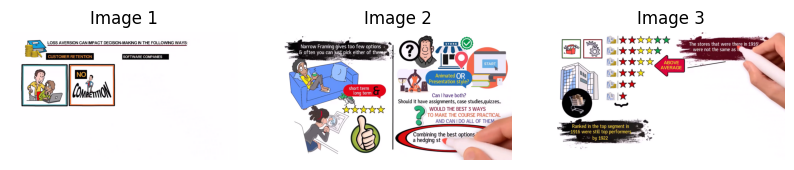


  The text chunk 3: euros , and you 're sure to make a choice that will make you more satisfied and happier . until the next video , have fun ! hey there , super excited to dive into the fascinating world of cognitive bi ases with you today . and , you know , it 's kind of funny how we humans think we 're like so smart and rational , but the truth is we 're all suscep tible


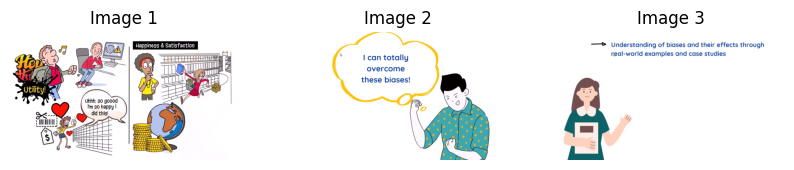


  The text chunk 4: . at the same time , companies observe this and conclude , well , being in silicon valley is doing wonders for them . maybe we should move there too . so , we would have more companies coming to silicon valley , potentially leading to more tech innovation . so , we have point a , which leads to point b , which once more leads to point a . this is called the mutual cau


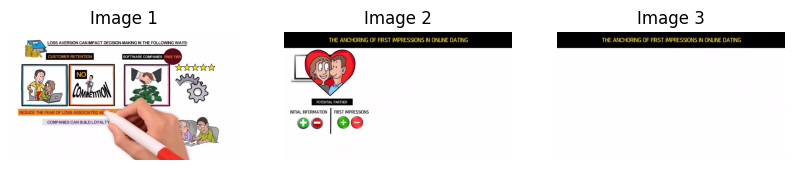


  The text chunk 5: pol ate until they found a year it would reach 1 0 0 %. now , you could say , okay , dio go , this is ridiculous . no one would extra pol ate like this . to which i reply , well , go check for yourself . go to google and search for , will all americans be overweight ? and it should be one of the first hits . it is quite obvious


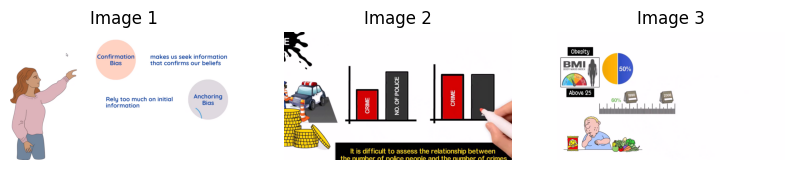

In [55]:
# Data visualization of the text and images
for i, text_index in enumerate(random_text_indices):
  plt.figure(figsize = (10,8))

   # Displaying the text chunk
  print(f"""
  The text chunk {i + 1}: {' '.join([tokenizer.decode([token]) for token in transcription_chunks[text_index]]
  )}""")

  # Displaying similar images corresponding to the current text chunk
  for j, image_idx in enumerate(text_to_images_similarities[i]):
    image = Image.open(image_paths[image_idx])
    plt.subplot(1, 3, j + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Image {j + 1}")

  plt.show() # Show the plot with images and text

# Step 9 - Retrival system

In [57]:
# Let's define a query
query = "Which cognitive biases are discussed?"

In [58]:
# Tokenizing the query
query_tokens = tokenizer(query,
                         return_tensors = "pt",       # Return tensors in PyTorch format
                         padding = True)['input_ids'] # Pad tokens to ensure consistent length

In [59]:
# Generate the query embeddings in the joint embedding space
# Use the CLIP model to compute text features
with torch.no_grad():
  query_embedding = model.get_text_features(
      input_ids = query_tokens  # Pass tokenized query to model
  ).cpu().numpy().flatten()     # Convert to numpy array and flatten to 1D

# Print shape of the embedding
print(f"The shape of the query embedding is {query_embedding.shape}")

The shape of the query embedding is (512,)


In [ ]:
# Compute the cosine similarity between the query and the transcripts
text_similarities = cosine_similarity([query_embedding], text_embedding_np)[0]
text_similarities

In [61]:
# Define how many chunks we want
top_k_texts = 10

# Retrieve the indices of the top-k most similar text_chunks
top_k_text_indices = text_similarities.argsort()[-top_k_texts:][::-1]
top_k_text_indices

array([128,  46, 100, 103,   0,  37,  92,  27,  65,  25])

In [62]:
# Retrieve the closest images for each text chunk
top_k_images_indices = []
images_per_chunk = 2 # Number of top similar images to retrieve for each text chunk

for idx in top_k_text_indices:
  # Find indices of the top-k similar images for the current text chunk
  similar_images = similarities[idx].argsort()[-images_per_chunk:][::-1]
  top_k_images_indices.append(similar_images)  # Add to the list

# Remove any duplicates and limit to the top k images
top_k_images_indices = list(set([item for sublist in top_k_images_indices for item in sublist]))

# Print the number of unique image indices
print(f"The total images indices are {len(top_k_images_indices)}")

The total images indices are 14


# Step 10 - Generation system

In [63]:
import base64

In [64]:
# Combining the retrieved text chunks
retrieved_text = []

for idx in top_k_text_indices:
  # Decode and append each text chunk using the tokenizer
  retrieved_text.append(tokenizer.decode(transcription_chunks[idx]))

# Join all the text chunks into a single string
retrieved_text = ' '.join(retrieved_text)
retrieved_text

"hmm , this is actually important , would you share it with me ? if you have any stories on decision making that you think are thought provoking or interesting , please do share . i love to hear other people 's stories . <|endoftext|> interact with each other . participants are asked to perform two tasks at the same time , such as counting backwards while solving a math problem . the results of these experiments provide insight into how system 1 and system 2 thinking compete for attention and resources , and how this competition affects our performance on different tasks . this experiment shows that our attention and cognitive resources are limited and that our distractions and competing activated . what they should have done was to look at all the mutual funds they had in 1 9 9 5 , and looked into their performance 1 0 years later . this is called survival bias . it happens when there is data that you don 't account for . in our case , morningstar 's funds that were not performing so 

In [65]:
# Convert the images and append them
base64frames = []

for idx in top_k_images_indices:
  image_path = image_paths[idx]  # Get the path of the image

  # Open the image file in binary read mode
  with open(image_path, "rb") as image_file:
    # Encode the image file content to base64 and decode to UTF-8 string
    base64_image = base64.b64encode(image_file.read()).decode('utf-8')
    base64frames.append(base64_image) # Append the encoded image string to the list

base64frames

['iVBORw0KGgoAAAANSUhEUgAABQAAAALQCAIAAABAH0oBAAEAAElEQVR4nOy9d3wfR53//56ZLZ+mZlWrWJbl3hTXxHac2Cl2CgmkQoAAx8EdhF7uLsc3hHD8uOMI7Q5yBxwQSkiAQAopJE6xncSOS9wtV1m9d32kT9kyM78/5vNZrT5FlmzLJZrnQ1E+Xu1nd3Z3dnde826IMw4SiUQikUgmDgSf+dRn/+dnjyDAHNh9//iZn/zkJ0gBYADoQrdNIpFIJJLJBL7QDZBIJBKJRCKRSCQSieR8IAWwRCKRSCQSiUQikUgmBVIASyQSiUQikUgkEolkUiAFsEQikUgkEolEIpFIJgVSAEskEolEIpFIJBKJZFIgBbBEIpFIJOcVzjnnsgSDRCKRSCQXACmAJRKJRCKRSCQSiUQyKZACWCKRSCSS8420AEskEolEckGQAlgikUgkkvOKVL8SiUQikVwopACWSCQSieR8IzWwRCKRSCQXBCmAJRKJRCKRSCQSiUQyKZACWCKRSCQSiUQikUgkkwIpgCUSiUQikUgkEolEMimQAlgikUgkEolEIpFIJJMCKYAlEolEIpFIJBKJRDIpkAJYIpFIJBKJRCKRSCSTAimAJRKJRCKRSCQSiUQyKZACWCKRSCQSiUQikUgkkwIpgCUSiUQikUgkEolEMimQAlgikUgkEolEIpFIJJMCKYAlEolEIpFIJBKJRDIpkAJYIpFIJBKJRCKRSCSTAimAJRKJRCKRSCQSiUQyKZACWCKRSCQSiUQikUgkkwIpgCUSiUQikUgkEolEMimQAlgikUgkEolEIpFIJJMCKYAlEolEIpFIJBKJRDIpkAJYIpFIJBKJRCKRSCSTAimAJRKJRCKRSCQSiUQyKZACWCKRSCQSiUQikUgkkwIpgCUSiUQikUgkEolEMimQAlgikUgkEolEIpFIJJMCKYAlEolEIpFIJBKJRDIpkAJYIpFIJBKJRCKRSCSTAimAJR

In [66]:
# Define the model
MODEL = "gpt-4o-mini"

# Define the system prompt
system_prompt = """
You are an expert teacher that summarises visual and transcribed content
"""

In [67]:
# Prepare the user message content
user_message_content = [
    "These are the frames from the video",                                # Initial message indicating the following content
    *map(lambda x: {"type": "image_url",                                  # Map each base64-encoded image to the appropriate format
                    "image_url": {"url": f'data:image/jpg;base64,{x}',
                                 "detail": "high"}},
         base64frames),
    {"type": "text",                                                      # Append the retrieved text as a separate message
     "text": retrieved_text}
]

In [68]:
# Call the OpenAI API to generate a summary
response = client.chat.completions.create(
    model = MODEL, # Specify the model to use for the completion
    messages = [
        {"role": "system", "content": system_prompt}, # Provide system prompt to guide the model
        {"role": "user", "content": user_message_content}, # Provide user message content with images and text
    ],
    temperature = 0.3,  # Set the temperature to control the randomness of the output
)

In [69]:
# Generate the response
generated_response = response.choices[0].message.content
print(generated_response)

The video frames you shared cover various aspects of decision-making, biases, and cognitive processes. Here's a summary of the key concepts:

1. **Biases in Decision-Making**:
   - The frames highlight different biases that affect how we make decisions, such as **confirmation bias**, **anchoring bias**, and **survivorship bias**. These biases can distort our perception and lead to suboptimal choices.

2. **System 1 and System 2 Thinking**:
   - The video introduces the concepts of **System 1** (fast, intuitive thinking) and **System 2** (slow, deliberate thinking). It emphasizes how these systems compete for attention and resources, impacting our decision-making processes.

3. **Framing Effects**:
   - The way information is presented (framed) can significantly influence decisions. For instance, describing outcomes in terms of gains versus losses can lead to different choices, even if the underlying facts are the same.

4. **Narrow Framing**:
   - This concept refers to limiting option